In [77]:
!pip install -q transformers datasets evaluate

Download Toy Dataset

In [78]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Define Pytorch Dataset and Dataloaders

In [80]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Initialize training and validation datasets

In [81]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [82]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Verify random sample

In [83]:
encoded_inputs = train_dataset[0]

In [84]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [85]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [86]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [87]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Define corresponding dataloaders

In [88]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [89]:
batch = next(iter(train_dataloader))

In [90]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [91]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [92]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True, False]]])

In [93]:
batch["labels"][mask]

tensor([5, 5, 5,  ..., 0, 0, 0])

Define the model

In [109]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.wei

Fine-tune the model

In [95]:
import evaluate

metric = evaluate.load("mean_iou")

In [96]:
image_processor.do_reduce_labels

True

In [97]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()

results = []  # Initialize a list to store results for each logging step
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])
          # Append current results to the list
          results.append({
              "epoch": epoch,
              "batch_idx": idx,
              "loss": loss.item(),
              "mean_iou": metrics["mean_iou"],
              "mean_accuracy": metrics["mean_accuracy"]
          })

# After training, convert the results list to a DataFrame and save it to CSV
df = pd.DataFrame(results)
df.to_csv('training_results.csv', index=False)

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.07410192489624
Mean_iou: 0.0001619505253929467
Mean accuracy: 0.0017028492261142866
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.853119373321533
Mean_iou: 0.0033000819938631535
Mean accuracy: 0.03270307613969849
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.692729949951172
Mean_iou: 0.0063162390182782075
Mean accuracy: 0.05205804439372754
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.592158317565918
Mean_iou: 0.01964569079282151
Mean accuracy: 0.23293374684585633
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.414376735687256
Mean_iou: 0.03176499656216618
Mean accuracy: 0.19821377796409662
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.2636823654174805
Mean_iou: 0.05814851961915769
Mean accuracy: 0.36206576623880077
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.083768367767334
Mean_iou: 0.08675950483128347
Mean accuracy: 0.36070296569997107
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.886751651763916
Mean_iou: 0.19020112461565727
Mean accuracy: 0.45389090265391613
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4959287643432617
Mean_iou: 0.09711325769933948
Mean accuracy: 0.21481107349366152
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6736299991607666
Mean_iou: 0.06834874855914004
Mean accuracy: 0.15144911429102711
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6250178813934326
Mean_iou: 0.18038940185589455
Mean accuracy: 0.4083179593539771
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3727705478668213
Mean_iou: 0.1528659800653806
Mean accuracy: 0.24299196459923372
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7566378116607666
Mean_iou: 0.12610079048818187
Mean accuracy: 0.5219608004167405
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.61818790435791
Mean_iou: 0.1197376622265842
Mean accuracy: 0.4843401330298833
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.844095468521118
Mean_iou: 0.19187065204674517
Mean accuracy: 0.39920934045181045
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2042617797851562
Mean_iou: 0.1413122465704434
Mean accuracy: 0.2728944990481115
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1020805835723877
Mean_iou: 0.2448966381174144
Mean accuracy: 0.4647269569914048
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.075669288635254
Mean_iou: 0.1642637421790004
Mean accuracy: 0.2958995599005164
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9920432567596436
Mean_iou: 0.20192689954682844
Mean accuracy: 0.3509603257179039
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.099421262741089
Mean_iou: 0.13417604968847907
Mean accuracy: 0.22364549349981036
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2078161239624023
Mean_iou: 0.15728766466964483
Mean accuracy: 0.2789312326589354
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6613402366638184
Mean_iou: 0.2469734763460798
Mean accuracy: 0.419932430696312
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6276209354400635
Mean_iou: 0.16113497857564643
Mean accuracy: 0.2552327366257516
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.708357334136963
Mean_iou: 0.12153446552268123
Mean accuracy: 0.2025281812932314
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2196056842803955
Mean_iou: 0.20107434264990792
Mean accuracy: 0.33581398467889795
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5695598125457764
Mean_iou: 0.3032813335015827
Mean accuracy: 0.439180774205103
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4878859519958496
Mean_iou: 0.3975654385705967
Mean accuracy: 0.6688298152654922
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7291020154953003
Mean_iou: 0.1853885089456567
Mean accuracy: 0.270274447167763
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.695358991622925
Mean_iou: 0.3044480431196045
Mean accuracy: 0.5533371645209565
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6403778791427612
Mean_iou: 0.286332066916823
Mean accuracy: 0.5661399359226748
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1167612075805664
Mean_iou: 0.4555015649311164
Mean accuracy: 0.5796685946562273
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5911359786987305
Mean_iou: 0.19216149481026612
Mean accuracy: 0.3749905114982167
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.291091203689575
Mean_iou: 0.20682420477274735
Mean accuracy: 0.3661139998491624
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3539013862609863
Mean_iou: 0.3021477919907051
Mean accuracy: 0.46578993399099716
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.167454957962036
Mean_iou: 0.33133112541882553
Mean accuracy: 0.529318361489913
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7283544540405273
Mean_iou: 0.18743740832304295
Mean accuracy: 0.3689946401248262
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2546091079711914
Mean_iou: 0.2405489940356581
Mean accuracy: 0.3665441966621072
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0059103965759277
Mean_iou: 0.2041923014622839
Mean accuracy: 0.33939840122623055
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6508985757827759
Mean_iou: 0.18626326608518956
Mean accuracy: 0.3687856513943517
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.882693886756897
Mean_iou: 0.22134541920920794
Mean accuracy: 0.30350836697647854
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7847256660461426
Mean_iou: 0.34998915390058866
Mean accuracy: 0.4802709790198632
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0458903312683105
Mean_iou: 0.38335456849636246
Mean accuracy: 0.5187483423753072
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.90632164478302
Mean_iou: 0.2965065938752927
Mean accuracy: 0.3923257467989036
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1909176111221313
Mean_iou: 0.3093794221502554
Mean accuracy: 0.4540500346509386
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9802297949790955
Mean_iou: 0.6283530683855475
Mean accuracy: 0.7354474006776334
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5502249002456665
Mean_iou: 0.5428371012908167
Mean accuracy: 0.731161960693875
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2399166822433472
Mean_iou: 0.18114957552551408
Mean accuracy: 0.26346244710872924
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5682226419448853
Mean_iou: 0.4196127312075784
Mean accuracy: 0.5443674234670042
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8534177541732788
Mean_iou: 0.6936444453641943
Mean accuracy: 0.8283110408807846
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6348303556442261
Mean_iou: 0.4576862600921571
Mean accuracy: 0.5943045099267856
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4770363569259644
Mean_iou: 0.3746155643356697
Mean accuracy: 0.4476555858637632
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.660104751586914
Mean_iou: 0.26754067302073287
Mean accuracy: 0.3838424483355396
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7579019665718079
Mean_iou: 0.6271302443394285
Mean accuracy: 0.8241077880557622
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2337278127670288
Mean_iou: 0.4119785873416905
Mean accuracy: 0.5085774898398626
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4517865180969238
Mean_iou: 0.38694632801728585
Mean accuracy: 0.4833734372099979
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1233000755310059
Mean_iou: 0.3697522449424871
Mean accuracy: 0.5122544137024551
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0434356927871704
Mean_iou: 0.3304485833614508
Mean accuracy: 0.6054343531612146
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4451520442962646
Mean_iou: 0.2551747899210701
Mean accuracy: 0.33713818918165145
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4244908094406128
Mean_iou: 0.39608442472149114
Mean accuracy: 0.5673705497080228
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2763370275497437
Mean_iou: 0.29426178024583605
Mean accuracy: 0.38135991581224027
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7276802062988281
Mean_iou: 0.44906389733227847
Mean accuracy: 0.5144938307604128
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2491964101791382
Mean_iou: 0.21907392908926945
Mean accuracy: 0.30416681691660485
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9732151031494141
Mean_iou: 0.4062074909964879
Mean accuracy: 0.6160049429424957
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6949917078018188
Mean_iou: 0.5286686545936764
Mean accuracy: 0.8247064162795741
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2177540063858032
Mean_iou: 0.41649177535245174
Mean accuracy: 0.49065241018048544
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9420528411865234
Mean_iou: 0.2920348248508566
Mean accuracy: 0.37304165870339234
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.274126410484314
Mean_iou: 0.13959673704544892
Mean accuracy: 0.2069788512130756
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3048466444015503
Mean_iou: 0.3378009193423565
Mean accuracy: 0.4131255418316185
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2477284669876099
Mean_iou: 0.43743813148728744
Mean accuracy: 0.5836973998925679
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2007142305374146
Mean_iou: 0.4525344549183186
Mean accuracy: 0.5710786111930661
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6191059947013855
Mean_iou: 0.533857205256674
Mean accuracy: 0.7583564172205952
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0556581020355225
Mean_iou: 0.17551151458931052
Mean accuracy: 0.3159691357953278
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.001660943031311
Mean_iou: 0.2688251187659354
Mean accuracy: 0.33361227081278666
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9814997911453247
Mean_iou: 0.5991614215190775
Mean accuracy: 0.7870077478575581
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2337520122528076
Mean_iou: 0.45381974923131096
Mean accuracy: 0.5422821038059035
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0406638383865356
Mean_iou: 0.46070795220495064
Mean accuracy: 0.5771793493628535
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0718879699707031
Mean_iou: 0.29657275294991287
Mean accuracy: 0.38244259580671325
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3176054954528809
Mean_iou: 0.1449735030521866
Mean accuracy: 0.2172899903317215
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9672869443893433
Mean_iou: 0.5179794157353009
Mean accuracy: 0.6314798450507011
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8964035511016846
Mean_iou: 0.13810757570005402
Mean accuracy: 0.2028070130451228
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42735555768013
Mean_iou: 0.6959431082566085
Mean accuracy: 0.7964622132606978
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7812487483024597
Mean_iou: 0.23890769892021094
Mean accuracy: 0.29712501858187285
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8724938035011292
Mean_iou: 0.2783674685327703
Mean accuracy: 0.35349934634147473
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8856432437896729
Mean_iou: 0.5235526306061933
Mean accuracy: 0.617100741311524
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8667542338371277
Mean_iou: 0.7282578592027474
Mean accuracy: 0.8595983472705621
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8333041667938232
Mean_iou: 0.33557774802389956
Mean accuracy: 0.519230580953612
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0672359466552734
Mean_iou: 0.39943576596578145
Mean accuracy: 0.47951439762435477
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.734149694442749
Mean_iou: 0.3684675786883636
Mean accuracy: 0.409234769178056
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7718783617019653
Mean_iou: 0.48720542815381823
Mean accuracy: 0.5595794456320515
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7949525713920593
Mean_iou: 0.13459638353395503
Mean accuracy: 0.1951960277062349
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5416469573974609
Mean_iou: 0.35469068308756563
Mean accuracy: 0.6682112046313439
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7884835004806519
Mean_iou: 0.5994224397907294
Mean accuracy: 0.6824254906290805
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6442065834999084
Mean_iou: 0.33404975781224816
Mean accuracy: 0.4664261763110212
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4387863874435425
Mean_iou: 0.4284726706288378
Mean accuracy: 0.5671560377205626
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.918649435043335
Mean_iou: 0.25739054415487733
Mean accuracy: 0.3017169591633304
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9066375494003296
Mean_iou: 0.2951490911179576
Mean accuracy: 0.34517385737295736
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7903135418891907
Mean_iou: 0.3154104310596745
Mean accuracy: 0.34559794785870174
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0485515594482422
Mean_iou: 0.19604127564635607
Mean accuracy: 0.2513014740855696
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5308908224105835
Mean_iou: 0.5049935645973787
Mean accuracy: 0.605633598168111
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.901688277721405
Mean_iou: 0.18254594227045648
Mean accuracy: 0.26431377918979854
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.721310555934906
Mean_iou: 0.2540235375638907
Mean accuracy: 0.41402505153326397
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6940664052963257
Mean_iou: 0.2979640743486972
Mean accuracy: 0.42301925289326936
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6578847169876099
Mean_iou: 0.25294862648990646
Mean accuracy: 0.4715233833965301
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7134767770767212
Mean_iou: 0.6278222353328362
Mean accuracy: 0.6681385791462549
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31052902340888977
Mean_iou: 0.7888762018280719
Mean accuracy: 0.9115258520023107
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6886900663375854
Mean_iou: 0.489405582747471
Mean accuracy: 0.538241000832351
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45928066968917847
Mean_iou: 0.31161516450776344
Mean accuracy: 0.5784734831441187
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8242366313934326
Mean_iou: 0.3997926457824117
Mean accuracy: 0.500704550878635
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7689732313156128
Mean_iou: 0.4259401099599211
Mean accuracy: 0.5073222867176534
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6022577285766602
Mean_iou: 0.5762961681580713
Mean accuracy: 0.6530012242718999
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8267209529876709
Mean_iou: 0.43668434700961584
Mean accuracy: 0.48917027811235614
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.500414252281189
Mean_iou: 0.7446396740296546
Mean accuracy: 0.8516854428357774
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8187764883041382
Mean_iou: 0.4361163560966167
Mean accuracy: 0.4866979241149076
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5958765149116516
Mean_iou: 0.42165094623483435
Mean accuracy: 0.4635006479196996
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38623958826065063
Mean_iou: 0.3839315435179236
Mean accuracy: 0.6202322208907084
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5054837465286255
Mean_iou: 0.31783804319305203
Mean accuracy: 0.5178293322668057
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3200947940349579
Mean_iou: 0.5480132771533198
Mean accuracy: 0.6096469636824973
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6207561492919922
Mean_iou: 0.5064354349586525
Mean accuracy: 0.5588537808492792
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5907305479049683
Mean_iou: 0.19465775093919654
Mean accuracy: 0.291267950634256
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7361965775489807
Mean_iou: 0.29737986374131786
Mean accuracy: 0.34684318688394433
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4574315547943115
Mean_iou: 0.4509630795201353
Mean accuracy: 0.5510322106193853
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5709035992622375
Mean_iou: 0.3129079772719417
Mean accuracy: 0.3586803425633838
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6513557434082031
Mean_iou: 0.5953392312782696
Mean accuracy: 0.6728363572222719
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.725250780582428
Mean_iou: 0.3182926385808167
Mean accuracy: 0.3658310396502619
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6515403985977173
Mean_iou: 0.40072413403897716
Mean accuracy: 0.4703403822651422
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1461859494447708
Mean_iou: 0.33147127372292107
Mean accuracy: 0.7140333683822738
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6843235492706299
Mean_iou: 0.4159663188244824
Mean accuracy: 0.5022154201177507
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37828508019447327
Mean_iou: 0.43749422140571237
Mean accuracy: 0.6980475909077062
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17778296768665314
Mean_iou: 0.8351916198093007
Mean accuracy: 0.8522711988455197
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46133118867874146
Mean_iou: 0.27401460946026834
Mean accuracy: 0.4980437948750221
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14013759791851044
Mean_iou: 0.3895590985811159
Mean accuracy: 0.6932384196276892
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5878888964653015
Mean_iou: 0.49187891990723986
Mean accuracy: 0.5404317499919153
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3541516363620758
Mean_iou: 0.45281247995604745
Mean accuracy: 0.7620784257800849
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4024674594402313
Mean_iou: 0.43101801480650354
Mean accuracy: 0.565687981275188
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6347744464874268
Mean_iou: 0.3236789918438216
Mean accuracy: 0.3842568022314573
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45860379934310913
Mean_iou: 0.7181911457723923
Mean accuracy: 0.7584391960886623
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.555134654045105
Mean_iou: 0.5156747226004014
Mean accuracy: 0.5669560291912497
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2721709609031677
Mean_iou: 0.5546637514288985
Mean accuracy: 0.6158905002404393
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16016198694705963
Mean_iou: 0.40070685476983603
Mean accuracy: 0.6667840238981805
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36027294397354126
Mean_iou: 0.9006890203123592
Mean accuracy: 0.9251733668055159
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24891838431358337
Mean_iou: 0.5543082686352998
Mean accuracy: 0.6022780823288267
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15334033966064453
Mean_iou: 0.8400640065230276
Mean accuracy: 0.8536991250345424
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6553874611854553
Mean_iou: 0.5524895645529295
Mean accuracy: 0.6408864036433505
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4323787987232208
Mean_iou: 0.6503982926627865
Mean accuracy: 0.6904399663540302
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5205747485160828
Mean_iou: 0.4731572185984192
Mean accuracy: 0.5114367647894505
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4866369068622589
Mean_iou: 0.40533537293678645
Mean accuracy: 0.4713981157118344
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3371964395046234
Mean_iou: 0.9116074868555738
Mean accuracy: 0.9395385687435928
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25721102952957153
Mean_iou: 0.532097377865707
Mean accuracy: 0.7725978443739691
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3193780183792114
Mean_iou: 0.8405300362856036
Mean accuracy: 0.8753750104235848
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7016680836677551
Mean_iou: 0.34191129020779937
Mean accuracy: 0.3926782943655258
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2262231707572937
Mean_iou: 0.8778129169759261
Mean accuracy: 0.9049911569436255
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5443176627159119
Mean_iou: 0.5650535256780169
Mean accuracy: 0.656708850195222
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4717870354652405
Mean_iou: 0.48745358482094275
Mean accuracy: 0.5245819566258346
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14569348096847534
Mean_iou: 0.955415791162356
Mean accuracy: 0.9683882083947345
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6301189064979553
Mean_iou: 0.3687074060965404
Mean accuracy: 0.4173726840059612
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4946289658546448
Mean_iou: 0.4903978061335198
Mean accuracy: 0.5751405859208705
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.573004961013794
Mean_iou: 0.4928898567250805
Mean accuracy: 0.5408330656116724
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5382334589958191
Mean_iou: 0.5849810114008696
Mean accuracy: 0.6203968332035724
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5119264721870422
Mean_iou: 0.5657816901809821
Mean accuracy: 0.6280030778540603
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4297260642051697
Mean_iou: 0.5765384261641572
Mean accuracy: 0.6983047323599235
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3741404414176941
Mean_iou: 0.7251214791154934
Mean accuracy: 0.7623443396890583
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5651864409446716
Mean_iou: 0.4662383847344579
Mean accuracy: 0.519151447236055
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4399218261241913
Mean_iou: 0.6145281169082093
Mean accuracy: 0.6873092571796746
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36346888542175293
Mean_iou: 0.33119207148703117
Mean accuracy: 0.5413215484246559
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2536027133464813
Mean_iou: 0.6736236939257185
Mean accuracy: 0.705543030893716
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4161553978919983
Mean_iou: 0.34263398682529494
Mean accuracy: 0.40581033674553263
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3478720784187317
Mean_iou: 0.35084971964813855
Mean accuracy: 0.5392688293006594
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5099137425422668
Mean_iou: 0.58758070874549
Mean accuracy: 0.622865316019597
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2696378827095032
Mean_iou: 0.464883404668733
Mean accuracy: 0.604041852918131
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25978216528892517
Mean_iou: 0.6628767542791159
Mean accuracy: 0.6951721033435398
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4724956154823303
Mean_iou: 0.4813165977873026
Mean accuracy: 0.5250801220539294
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5379678606987
Mean_iou: 0.49005155172391307
Mean accuracy: 0.531576420749125
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25438374280929565
Mean_iou: 0.6701992138701693
Mean accuracy: 0.7125430702649537
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3283640146255493
Mean_iou: 0.8419997669193364
Mean accuracy: 0.8779457893841254
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17711405456066132
Mean_iou: 0.4493400569188224
Mean accuracy: 0.7158544150577971
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3361445367336273
Mean_iou: 0.7364549445246624
Mean accuracy: 0.7823294444274715
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5751354098320007
Mean_iou: 0.3319296099210629
Mean accuracy: 0.3944642552737248
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4132782816886902
Mean_iou: 0.6227546952360482
Mean accuracy: 0.6853419827934805
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34693360328674316
Mean_iou: 0.5743058190385364
Mean accuracy: 0.6169534582891342
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12608353793621063
Mean_iou: 0.8449241278499483
Mean accuracy: 0.8576434509967933
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4172946512699127
Mean_iou: 0.21919249977481817
Mean accuracy: 0.3071395927198458
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3360980451107025
Mean_iou: 0.7540910625638668
Mean accuracy: 0.7942512172843177
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4809393286705017
Mean_iou: 0.31069790799900704
Mean accuracy: 0.39860539423862723
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.327995628118515
Mean_iou: 0.8221455736799598
Mean accuracy: 0.8588085805699692
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3330191969871521
Mean_iou: 0.7066855633622163
Mean accuracy: 0.7331117259757932
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2851082384586334
Mean_iou: 0.8603001918974458
Mean accuracy: 0.9689713727898797
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3992351293563843
Mean_iou: 0.5506261108650533
Mean accuracy: 0.5900372997998932
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.228420227766037
Mean_iou: 0.7263662912828586
Mean accuracy: 0.8249794385028413
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22109539806842804
Mean_iou: 0.644519121973111
Mean accuracy: 0.8497179098453903
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10559836775064468
Mean_iou: 0.8484057491414134
Mean accuracy: 0.8596441694816761
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4988100826740265
Mean_iou: 0.3518750992784407
Mean accuracy: 0.4340677732139149
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3592456877231598
Mean_iou: 0.6173926923050713
Mean accuracy: 0.6905652447952146
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10841991007328033
Mean_iou: 0.7509102534940522
Mean accuracy: 0.8604898825692171
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11777043342590332
Mean_iou: 0.8508350727250613
Mean accuracy: 0.8634529118239817
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4195685386657715
Mean_iou: 0.38401880585706333
Mean accuracy: 0.44329903132133347
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20924490690231323
Mean_iou: 0.4633649169487175
Mean accuracy: 0.6278436629684581
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1474713832139969
Mean_iou: 0.441488187793228
Mean accuracy: 0.7485455537526248
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2664487361907959
Mean_iou: 0.6701759821402494
Mean accuracy: 0.748781434284586
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26194077730178833
Mean_iou: 0.7209337245718392
Mean accuracy: 0.7445060826346844
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5318825840950012
Mean_iou: 0.34016052779071276
Mean accuracy: 0.3909038934714325


Inference

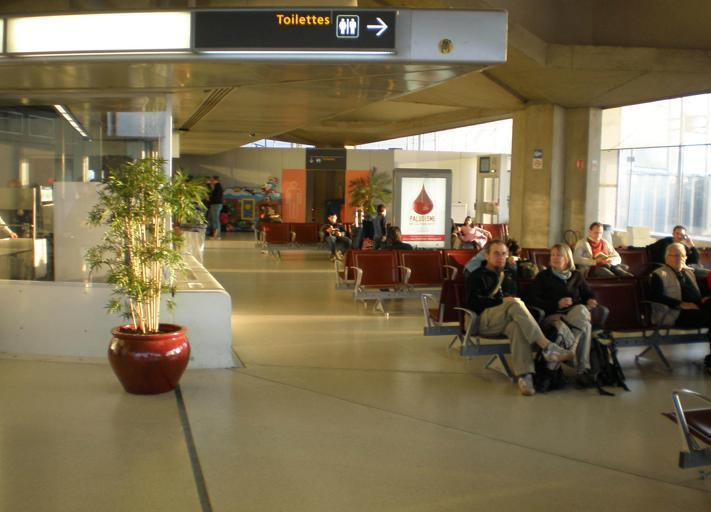

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [ ]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [98]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


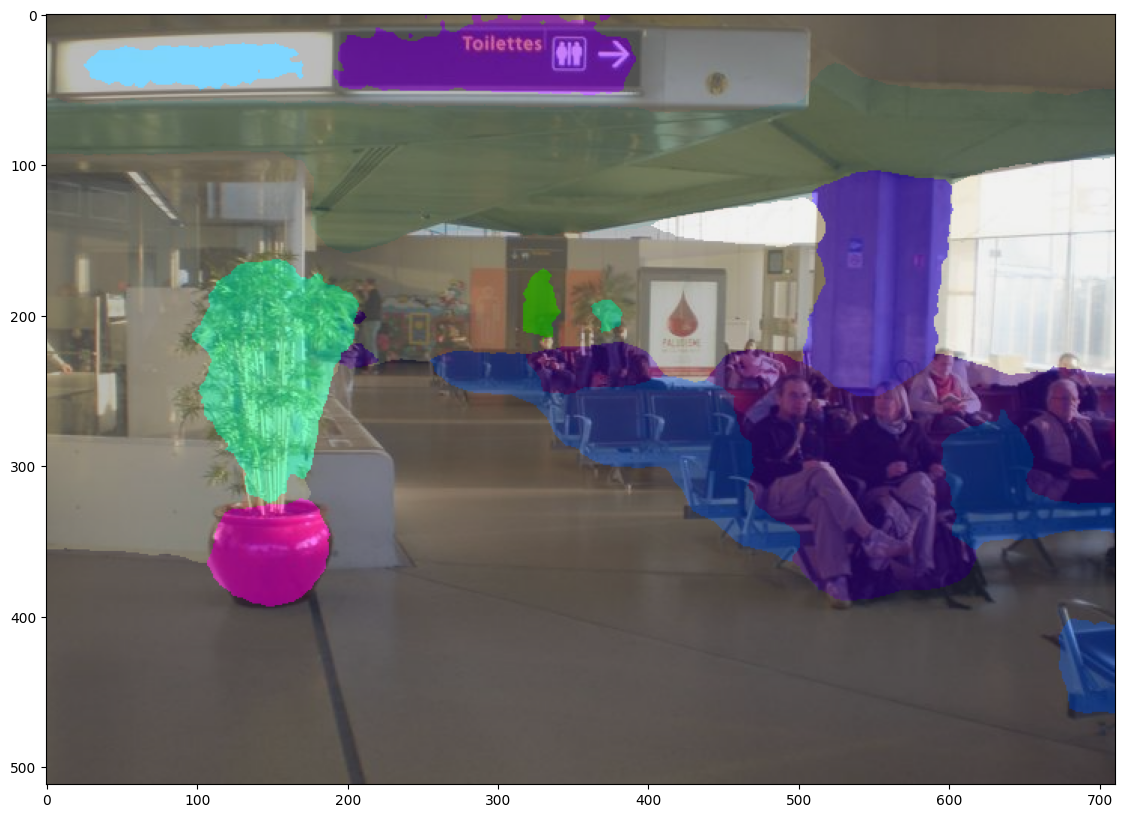

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth

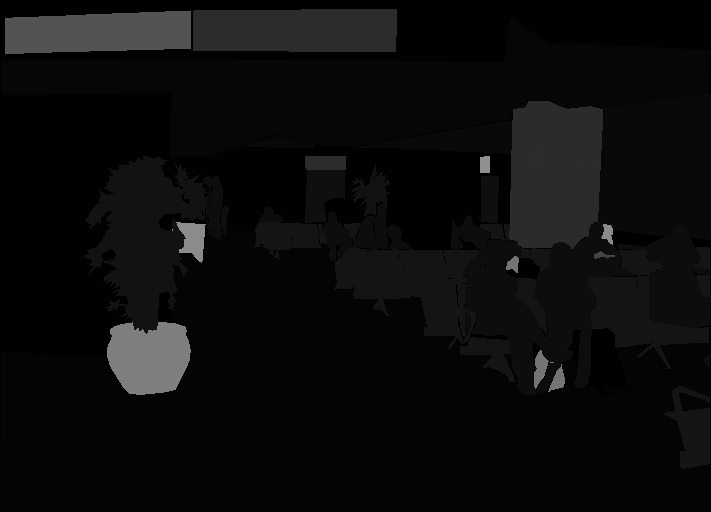

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


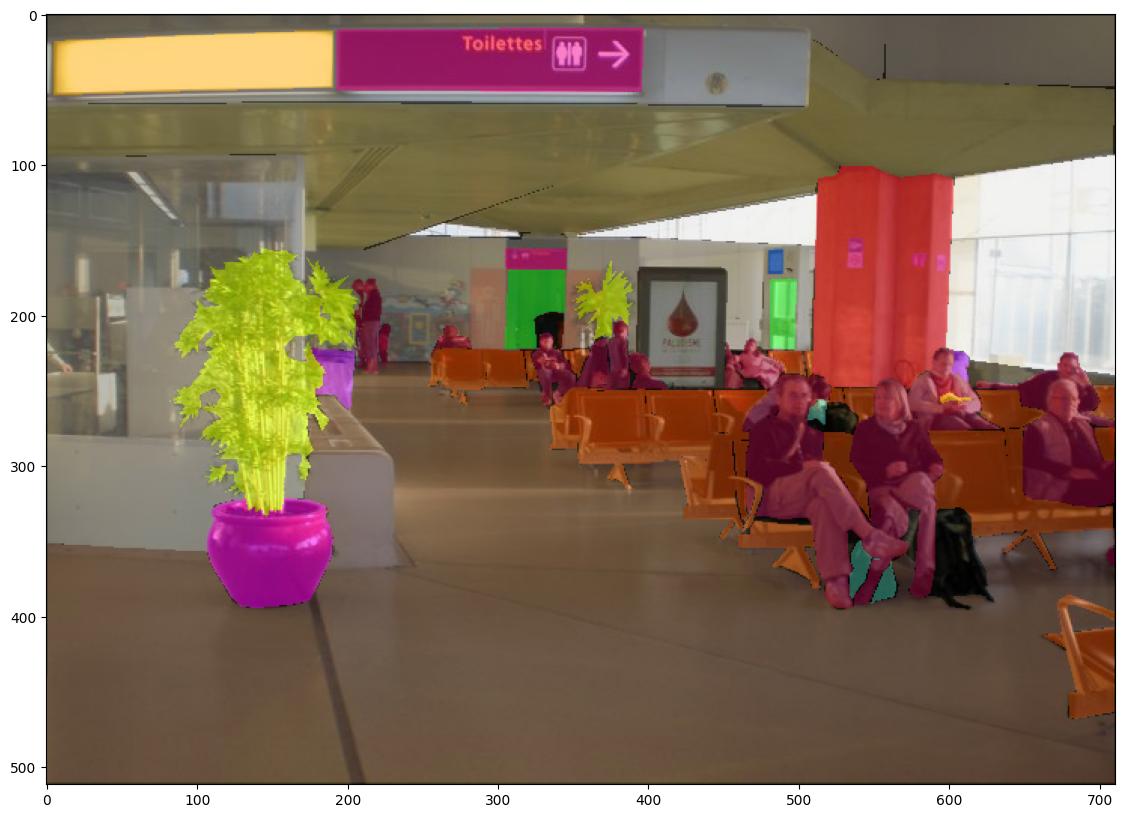

In [ ]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5564100278977232
mean_accuracy 0.6000395811477314
overall_accuracy 0.9171425557453093
---------------------
per-category metrics:


,IoU,accuracy
wall,0.799548,0.968151
building,NaN,NaN
sky,NaN,NaN
floor,0.964840,0.981717
tree,NaN,NaN
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN


In [ ]:
metric_table

{'wall': [0.7995475382508781, 0.9681512132527862],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9648397672193377, 0.981717340994334],
 'tree': [nan, nan],
 'ceiling': [0.928500108530497, 0.9472728480634232],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.9031646255554351, 0.9508785942492013],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.7083721931271971, 0.877298978231897],
 'earth': [nan, nan],
 'door': [0.2522783761391881, 0.2554530201342282],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.7262644814919469, 0.8099740014181045],
 'curtain': [nan, nan],
 'chair': [0.6759595605934614, 0.7434774237027053],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 'r

In [110]:
import torch
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import os
from torchvision import transforms
import pandas as pd

# Assuming 'train_dataset' is your PyTorch dataset for validation/testing
# Randomly sample 3 indices
indices = random.sample(range(len(train_dataset)), 3)

# Create a subset and corresponding DataLoader for these indices
sample_dataset = Subset(train_dataset, indices)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure your model is on the correct device
model = model.to(device)

# Function to decode segmentation maps into colored images
def decode_segmap(image, nc=150):
    palette = np.array(ade_palette())  # Define your palette function appropriately
    color_seg = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_seg[image == label, :] = color
    return color_seg[..., ::-1]  # Convert RGB to BGR if needed

# Metric initialization and update functions
def init_metrics(num_classes):
    return {
        'class_correct': np.zeros(num_classes),
        'class_total': np.zeros(num_classes),
        'class_intersection': np.zeros(num_classes),
        'class_union': np.zeros(num_classes)
    }

def update_metrics(metrics, predictions, labels, num_classes):
    for cls in range(num_classes):
        class_mask = (labels == cls)
        pred_mask = (predictions == cls)
        metrics['class_correct'][cls] += np.sum((predictions == labels) & class_mask)
        metrics['class_total'][cls] += np.sum(class_mask)
        metrics['class_intersection'][cls] += np.sum(pred_mask & class_mask)
        metrics['class_union'][cls] += np.sum(pred_mask | class_mask)

def finalize_metrics(metrics, num_classes):
    per_class_accuracy = np.divide(metrics['class_correct'], metrics['class_total'], out=np.zeros_like(metrics['class_correct']), where=metrics['class_total']!=0)
    per_class_iou = np.divide(metrics['class_intersection'], metrics['class_union'], out=np.zeros_like(metrics['class_intersection']), where=metrics['class_union']!=0)
    return per_class_accuracy, per_class_iou

def calc_mean_iou(per_class_iou):
    valid_iou = per_class_iou[~np.isnan(per_class_iou)]
    if valid_iou.size == 0:
        return float('nan')  # Return nan if no valid IoU values are present
    return np.mean(valid_iou)

from collections import defaultdict

def calculate_metrics(predictions, labels, num_classes):
    metrics = init_metrics(num_classes)
    update_metrics(metrics, predictions, labels, num_classes)
    per_class_accuracy, per_class_iou = finalize_metrics(metrics, num_classes)
    return per_class_accuracy, per_class_iou

# Directory to save images corresponding to accuracy and IoU
image_dir = '/content/results/images_with_metrics'
os.makedirs(image_dir, exist_ok=True)

# Processing loop
data_list = []
num_classes = 150  # Update this based on your model's output
metrics = init_metrics(num_classes)
model.eval()

with torch.no_grad():
    for i, batch in enumerate(sample_dataloader):
        images = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(images)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probs, dim=1).cpu().numpy()

        for j, (image, prediction, label) in enumerate(zip(images.cpu(), predictions, labels.cpu())):
            data_entry = {}
            prediction_resized = F.resize(torch.from_numpy(prediction).unsqueeze(0).unsqueeze(0),
                                          size=(label.shape[-2], label.shape[-1]),
                                          interpolation=F.InterpolationMode.NEAREST).squeeze().numpy()

            acc = (prediction_resized == label.numpy()).mean()
            # Calculate per-class metrics for the current image
            per_class_accuracy, per_class_iou = calculate_metrics(prediction_resized, label.numpy(), num_classes)
            # calculate mean iou
            mean_iou = calc_mean_iou(per_class_iou)

            pred_img = decode_segmap(prediction_resized)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(pred_img)
            plt.title('Predicted Segmentation')
            image_path = os.path.join(image_dir, f'sample_image_{i}_{j}.png')
            plt.savefig(image_path)
            plt.close()
            data_entry['Accuracy'] = acc
            data_entry['Mean IoU'] = mean_iou
            data_entry['Image Path'] = image_path
            # Adding per-class metrics
            for cls in range(num_classes):
              class_name = id2label[cls]
              data_entry[f'{class_name} Accuracy'] = per_class_accuracy[cls]
              data_entry[f'{class_name} IoU'] = per_class_iou[cls]
            data_list.append(data_entry)
df = pd.DataFrame(data_list)
df.to_csv('/content/results/metrics_with_images_and_classes.csv', index=False)


In [ ]:
# code to generate heatmaps

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/results/metrics_with_images_and_classes.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Extract columns for Accuracy and IoU
accuracy_columns = [col for col in data.columns if 'Accuracy' in col]
iou_columns = [col for col in data.columns if 'IoU' in col]

# Create heatmaps for Accuracy and IoU
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# Accuracy Heatmap
accuracy_data = data[accuracy_columns]
sns.heatmap(accuracy_data.T, ax=axes[0], cmap='viridis', cbar_kws={'label': 'Accuracy'})
axes[0].set_title('Accuracy across All Classes')
axes[0].set_xticklabels([])
axes[0].set_yticklabels([col.replace(' Accuracy', '') for col in accuracy_columns], rotation=0)

# IoU Heatmap
iou_data = data[iou_columns]
sns.heatmap(iou_data.T, ax=axes[1], cmap='viridis', cbar_kws={'label': 'IoU'})
axes[1].set_title('IoU across All Classes')
axes[1].set_xticklabels([])
axes[1].set_yticklabels([col.replace(' IoU', '') for col in iou_columns], rotation=0)

plt.tight_layout()
plt.show()

# Analysis output (You might want to customize this part based on specific needs or insights you gain from the heatmaps)
print("Heatmap analysis complete. Check the visual output for detailed insights into class performance.")
